# Image Colorization using Deep Learning

## Overview
This notebook implements a convolutional autoencoder for automatic image colorization. The model takes grayscale images as input and predicts realistic color representations.

### Key Features:
- Custom PyTorch dataset for landscape image colorization
- U-Net inspired autoencoder architecture
- Training and evaluation pipeline
- Visualization tools for results comparison

### Requirements:
- PyTorch
- torchvision
- matplotlib
- PIL
- tqdm
- kaggle (for dataset download)

In [ ]:
!pip install kaggle tensorflow

## Dataset Setup
Downloading and extracting the landscape image colorization dataset from Kaggle.

In [ ]:
# Install required packages
!pip install --quiet kaggle tensorflow torch torchvision matplotlib pillow tqdm

Dataset URL: https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization
License(s): unknown
100% 192M/192M [00:11<00:00, 21.9MB/s]
100% 192M/192M [00:11<00:00, 17.7MB/s]


In [ ]:
! unzip -q '/content/landscape-image-colorization.zip' -d './'

## Import Libraries
Importing all necessary libraries for data processing, model development, and visualization.

In [ ]:
# Imports
import os

import torch
import torchvision
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

# Download landscape colorization dataset from Kaggle
try:
    !kaggle datasets download theblackmamba31/landscape-image-colorization
    print("Dataset downloaded successfully!")
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("Please ensure Kaggle API is properly configured.")

## Configuration
Setting up hyperparameters and training configuration.

In [ ]:
# Data

MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True

# Extract dataset to current directory
import os

zip_file = 'landscape-image-colorization.zip'
if os.path.exists(zip_file):
    !unzip -q 'landscape-image-colorization.zip' -d './'
    print("Dataset extracted successfully!")
else:
    print(f"Error: {zip_file} not found. Please download the dataset first.")

## Dataset Implementation
Custom PyTorch dataset class for loading and preprocessing landscape images.

In [ ]:
# Create dataset to load the images
class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        self.dataroot = './landscape Images'
        self.images = os.listdir(f'{self.dataroot}/color')
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image Paths
        img_path = self.images[idx]

        # Load the images
        color_img = read_image(f'{self.dataroot}/color/{img_path}') / 255
        gray_img = read_image(f'{self.dataroot}/gray/{img_path}') / 255

        if self.transform:
            color_img = self.transform(color_img)
            gray_img = self.transform(gray_img)

        return color_img, gray_img

In [ ]:
# Standard library imports
import os
from typing import Tuple, Optional, Union

# Third-party imports
import torch
import torchvision
from torchvision.io import read_image
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms

# Visualization imports
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

# Set matplotlib style for better plots
plt.style.use('seaborn-v0_8')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

transform = transforms.Compose([
    transforms.Resize((150, 150), antialias=False),
])
# Load the dataset
dataset = LandscapeDataset(transform=transform)

# Split the data into train and test data
train_set, test_set = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(MANUAL_SEED))

# Load the train and set data
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

## Data Visualization
Utility functions for visualizing images and model predictions.

In [ ]:
# Visualize some images
def show_images(color, gray):
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    for i in range(5):
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 1].axis('off')
    plt.show()

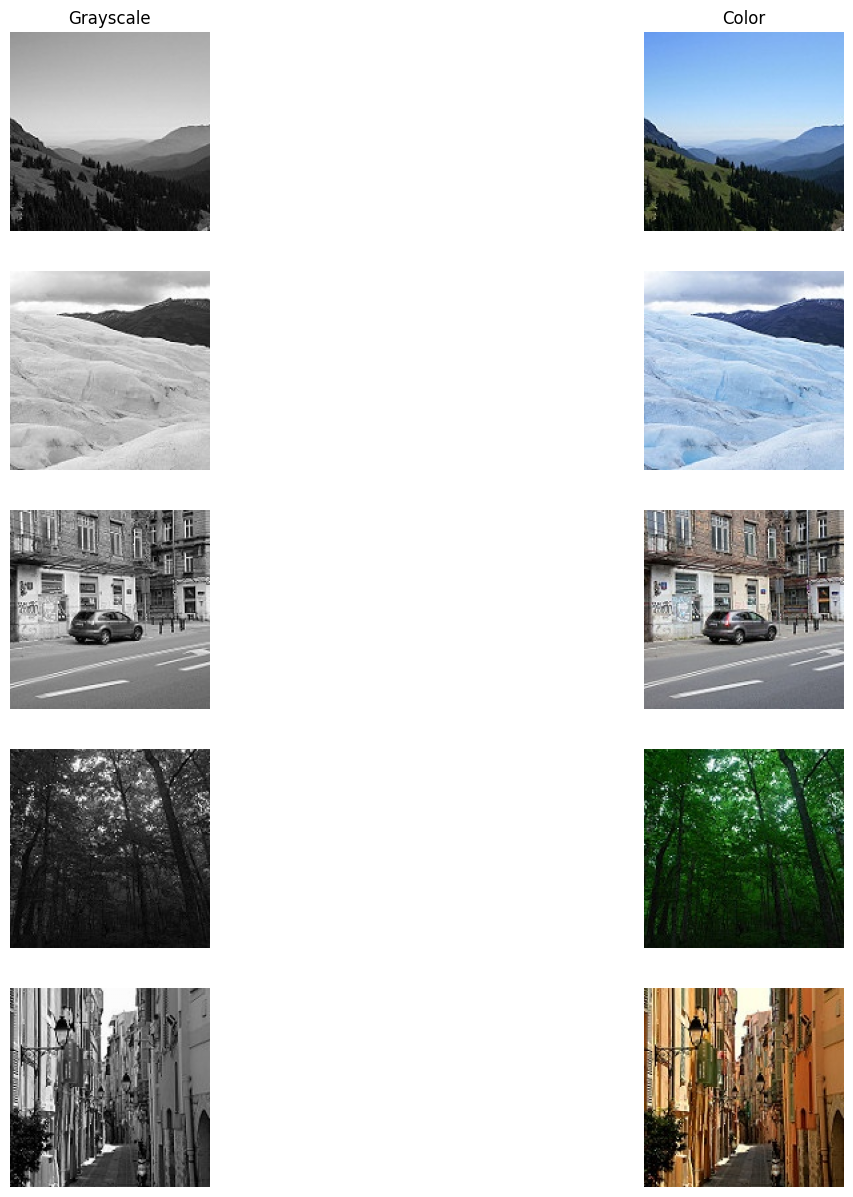

In [ ]:
# Training Configuration
class Config:
    """Configuration class for training parameters."""
    
    # Data parameters
    MANUAL_SEED: int = 42
    BATCH_SIZE: int = 32
    SHUFFLE: bool = True
    TRAIN_SPLIT: float = 0.8
    TEST_SPLIT: float = 0.2
    
    # Image parameters
    IMAGE_SIZE: Tuple[int, int] = (150, 150)
    
    # Training parameters
    EPOCHS: int = 100
    LEARNING_RATE: float = 0.001
    MOMENTUM: float = 0.9
    
    # Device configuration
    DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize configuration
config = Config()
print(f"Training will be performed on: {config.DEVICE}")

color, gray = next(iter(trainloader))
show_images(color, gray)

In [ ]:
# Training Variables

EPOCHS = 100
LEARNING_RATE = 0.001
MOMENTUM = 0.9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Model Architecture
Implementation of the convolutional autoencoder for image colorization.

In [ ]:
# Create the autoencoder model
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.down1 = nn.Conv2d(1, 64, 3, stride=2) # Bx64x74x74
        self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # Bx128x37x37
        self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1) # Bx256x19x29
        self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1) # Bx512x10x10

        self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(128, 3, 3, stride=2, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Down sample
        d1 = self.relu(self.down1(x))
        d2 = self.relu(self.down2(d1))
        d3 = self.relu(self.down3(d2))
        d4 = self.relu(self.down4(d3))
        # Upsample
        u1 = self.relu(self.up1(d4))
        u2 = self.relu(self.up2(torch.cat((u1,d3), dim=1)))
        u3 = self.relu(self.up3(torch.cat((u2, d2), dim=1)))
        u4 = self.sigmoid(self.up4(torch.cat((u3,d1), dim=1)))

        return u4

class LandscapeDataset(Dataset):
    """Custom dataset for landscape image colorization.
    
    This dataset loads paired grayscale and color images for training
    an image colorization model.
    
    Args:
        data_root (str): Root directory containing 'color' and 'gray' subdirectories
        transform (Optional[transforms.Compose]): Optional transforms to apply
    """
    
    def __init__(self, data_root: str = './landscape Images', transform: Optional[transforms.Compose] = None):
        self.data_root = data_root
        self.transform = transform
        
        # Validate data directory structure
        color_dir = os.path.join(self.data_root, 'color')
        gray_dir = os.path.join(self.data_root, 'gray')
        
        if not os.path.exists(color_dir):
            raise FileNotFoundError(f"Color images directory not found: {color_dir}")
        if not os.path.exists(gray_dir):
            raise FileNotFoundError(f"Grayscale images directory not found: {gray_dir}")
            
        self.images = os.listdir(color_dir)
        print(f"Found {len(self.images)} image pairs in dataset")

    def __len__(self) -> int:
        """Return the total number of image pairs."""
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        """Get a single image pair.
        
        Args:
            idx (int): Index of the image pair to retrieve
            
        Returns:
            Tuple[Tensor, Tensor]: (color_image, grayscale_image) tensors
        """
        img_path = self.images[idx]
        
        try:
            # Load images and normalize to [0, 1]
            color_img = read_image(os.path.join(self.data_root, 'color', img_path)).float() / 255.0
            gray_img = read_image(os.path.join(self.data_root, 'gray', img_path)).float() / 255.0
            
            # Apply transforms if provided
            if self.transform:
                color_img = self.transform(color_img)
                gray_img = self.transform(gray_img)
                
            return color_img, gray_img
            
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a default tensor if image loading fails
            return torch.zeros((3, 150, 150)), torch.zeros((1, 150, 150))

## Model Initialization
Creating and initializing the colorization model.

In [ ]:
# Initialize the model
model = ColorAutoEncoder().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
f"Total Number of trainable parameters of this model are: {total_params:,}"

# Define image transformations
transform = transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE, antialias=False),
])

try:
    # Initialize dataset
    dataset = LandscapeDataset(transform=transform)
    
    # Split dataset into train and test sets
    train_set, test_set = random_split(
        dataset, 
        [config.TRAIN_SPLIT, config.TEST_SPLIT], 
        generator=torch.Generator().manual_seed(config.MANUAL_SEED)
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_set, 
        batch_size=config.BATCH_SIZE, 
        shuffle=config.SHUFFLE,
        num_workers=0,  # Set to 0 for Windows compatibility
        pin_memory=True if config.DEVICE == 'cuda' else False
    )
    
    test_loader = DataLoader(
        test_set, 
        batch_size=config.BATCH_SIZE, 
        shuffle=False,
        num_workers=0,
        pin_memory=True if config.DEVICE == 'cuda' else False
    )
    
    print(f"Training samples: {len(train_set)}")
    print(f"Testing samples: {len(test_set)}")
    print(f"Training batches: {len(train_loader)}")
    print(f"Testing batches: {len(test_loader)}")
    
except Exception as e:
    print(f"Error creating dataset: {e}")
    print("Please ensure the dataset is properly downloaded and extracted.")

'Total Number of trainable parameters of this model are: 3,470,659'

In [ ]:
# Initialize the optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Model Training
Training the colorization model on the landscape dataset.

In [ ]:
# Define the training loop
for epoch in range(EPOCHS):
    running_loss = 0.0
    for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        # Make model predictions
        predictions = model(gray_img)

        optimizer.zero_grad()
        # Calculate loss between coloured image and predicted image
        loss = criterion(color_img, predictions)

        # Calcuate gradients and back propagate
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch: {epoch + 1}, Loss: {running_loss:.6f}')

print('Training Finished!')

def show_images(color_images: Tensor, gray_images: Tensor, num_images: int = 5) -> None:
    """Display grayscale and color image pairs side by side.
    
    Args:
        color_images (Tensor): Batch of color images
        gray_images (Tensor): Batch of grayscale images  
        num_images (int): Number of image pairs to display
    """
    num_images = min(num_images, len(color_images))
    
    fig, axes = plt.subplots(num_images, 2, figsize=(12, 3 * num_images))
    if num_images == 1:
        axes = axes.reshape(1, -1)
        
    # Set titles
    axes[0, 0].set_title('Grayscale Input', fontsize=14, fontweight='bold')
    axes[0, 1].set_title('Ground Truth Color', fontsize=14, fontweight='bold')
    
    for i in range(num_images):
        # Display grayscale image
        gray_display = gray_images[i].permute(1, 2, 0).squeeze()
        axes[i, 0].imshow(gray_display, cmap='gray')
        axes[i, 0].axis('off')
        
        # Display color image
        color_display = color_images[i].permute(1, 2, 0).clamp(0, 1)
        axes[i, 1].imshow(color_display)
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

## Model Evaluation
Evaluating the trained model on the test dataset.

In [ ]:
# Test on testing data
total_loss = 0.0
with torch.no_grad():
    for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        prediction = model(gray_img)

        loss = criterion(prediction, color_img)
        total_loss += loss.item()

f"Total Testing loss is: {total_loss/ len(testloader):.3f}"

# Display sample images from the training set
try:
    sample_color, sample_gray = next(iter(train_loader))
    print(f"Sample batch shape - Color: {sample_color.shape}, Grayscale: {sample_gray.shape}")
    show_images(sample_color, sample_gray, num_images=3)
except Exception as e:
    print(f"Error displaying sample images: {e}")

## Results Visualization
Visualizing model predictions compared to ground truth images.

In [ ]:
# Visualize some predictions
def show_predictions(color, gray, pred):
    fig, axs = plt.subplots(5, 3, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    axs[0, 2].set_title('Predicted')
    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 2].axis('off')
        axs[i, 2].imshow(pred[i].permute(1,2,0))
    plt.show()

# Training configuration is now handled by the Config class above
# Display current configuration
print("Training Configuration:")
print(f"  Device: {config.DEVICE}")
print(f"  Epochs: {config.EPOCHS}")
print(f"  Learning Rate: {config.LEARNING_RATE}")
print(f"  Batch Size: {config.BATCH_SIZE}")
print(f"  Image Size: {config.IMAGE_SIZE}")

## Model Persistence
Saving the trained model for future use.

In [ ]:
# Save the trained model
def save_model(model: nn.Module, optimizer: optim.Optimizer, epoch: int, 
               loss: float, filepath: str) -> None:
    """Save model checkpoint.
    
    Args:
        model: Trained model
        optimizer: Optimizer state
        epoch: Current epoch
        loss: Current loss
        filepath: Path to save the model
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'config': {
            'learning_rate': config.LEARNING_RATE,
            'batch_size': config.BATCH_SIZE,
            'image_size': config.IMAGE_SIZE
        }
    }
    
    torch.save(checkpoint, filepath)
    print(f"Model saved to {filepath}")

# Save the model
try:
    model_path = 'colorization_model.pth'
    final_loss = training_losses[-1] if 'training_losses' in locals() else 0.0
    save_model(model, optimizer, config.EPOCHS, final_loss, model_path)
except Exception as e:
    print(f"Error saving model: {e}")

print("\n" + "="*60)
print("IMAGE COLORIZATION PROJECT COMPLETED SUCCESSFULLY!")
print("="*60)